In [1]:
from __future__ import print_function

import os

import numpy as np
from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.losses import mean_squared_error
import csv
import matplotlib.pyplot as plt

np.random.seed(123)

Using TensorFlow backend.


In [23]:
a = np.arange(24).reshape(1,2,3,4)
np.tile(a,(2,2,2,2))

array([[[[ 0,  1,  2,  3,  0,  1,  2,  3],
         [ 4,  5,  6,  7,  4,  5,  6,  7],
         [ 8,  9, 10, 11,  8,  9, 10, 11],
         [ 0,  1,  2,  3,  0,  1,  2,  3],
         [ 4,  5,  6,  7,  4,  5,  6,  7],
         [ 8,  9, 10, 11,  8,  9, 10, 11]],

        [[12, 13, 14, 15, 12, 13, 14, 15],
         [16, 17, 18, 19, 16, 17, 18, 19],
         [20, 21, 22, 23, 20, 21, 22, 23],
         [12, 13, 14, 15, 12, 13, 14, 15],
         [16, 17, 18, 19, 16, 17, 18, 19],
         [20, 21, 22, 23, 20, 21, 22, 23]],

        [[ 0,  1,  2,  3,  0,  1,  2,  3],
         [ 4,  5,  6,  7,  4,  5,  6,  7],
         [ 8,  9, 10, 11,  8,  9, 10, 11],
         [ 0,  1,  2,  3,  0,  1,  2,  3],
         [ 4,  5,  6,  7,  4,  5,  6,  7],
         [ 8,  9, 10, 11,  8,  9, 10, 11]],

        [[12, 13, 14, 15, 12, 13, 14, 15],
         [16, 17, 18, 19, 16, 17, 18, 19],
         [20, 21, 22, 23, 20, 21, 22, 23],
         [12, 13, 14, 15, 12, 13, 14, 15],
         [16, 17, 18, 19, 16, 17, 18, 19],
     

In [2]:
def prepare_sequences(train_dir):
    x_train = []
    for each_csv_file in os.listdir(train_dir):
#         print(each_csv_file)
        one_csv = np.genfromtxt(os.path.join(train_dir, each_csv_file), delimiter=",")
        x_train.append(one_csv)
    x_train = np.array(x_train)
    return x_train

# x_train = prepare_sequences("/home/r.wang/git/deepsense/Parse_Raw_HHAR/fft_lstm_data/a/train")


In [3]:
%%bash

rm model.h5

rm: cannot remove 'model.h5': No such file or directory


x_test1.shape = (500, 20, 120)
x_test2.shape = (500, 20, 120)
x_test.shape = (1000, 20, 120)
x_train.shape = (5258, 20, 120)
Train on 5258 samples, validate on 1000 samples
Epoch 1/16
5258/5258 [==============================] - 6s - loss: 1478.2849 - acc: 0.8441 - val_loss: 1250.1991 - val_acc: 0.9233
Epoch 2/16
5258/5258 [==============================] - 4s - loss: 864.4051 - acc: 0.9918 - val_loss: 854.8931 - val_acc: 0.9270
Epoch 3/16
5258/5258 [==============================] - 5s - loss: 639.2348 - acc: 0.9913 - val_loss: 754.5705 - val_acc: 0.9279
Epoch 4/16
5258/5258 [==============================] - 4s - loss: 1881.3185 - acc: 0.9874 - val_loss: 1091.5383 - val_acc: 0.9211
Epoch 5/16
5258/5258 [==============================] - 4s - loss: 857.4831 - acc: 0.9879 - val_loss: 880.7183 - val_acc: 0.9242
Epoch 6/16
5258/5258 [==============================] - 4s - loss: 738.9626 - acc: 0.9926 - val_loss: 845.7296 - val_acc: 0.9294
Epoch 7/16
5258/5258 [===========================

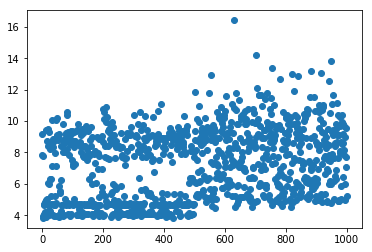

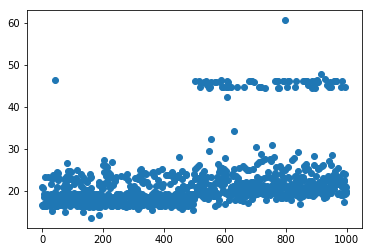

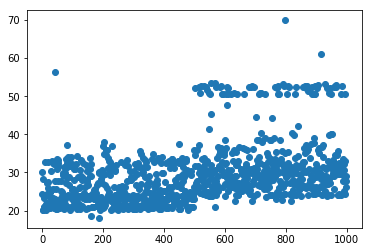

TypeError: unsupported operand type(s) for /: 'Dimension' and 'int'

In [4]:
def tp_fn_fp_tn(total, expected, actual):
    tp = len(set(expected).intersection(set(actual)))
    fn = len(set(expected) - set(actual))
    fp = len(set(actual) - set(expected))
    tn = len((total - set(expected)).intersection(total - set(actual)))
    return tp, fn, fp, tn

def main():
    window_length = 20
    select_only_last_state = False
    model_file = 'model.h5'
    hidden_dim = 240
    num_epoch = 16
    batch_size = 64
    feature_size = 120
    input_shape=(window_length, feature_size)
    x_train_dir = "/home/r.wang/ruowen_git/deepsense/Parse_Raw_HHAR/train_fft_lstm_data/a/train"
    x_test1_dir = "/home/r.wang/ruowen_git/deepsense/Parse_Raw_HHAR/train_fft_lstm_data/a/eval"
    x_test2_dir = "/home/r.wang/ruowen_git/deepsense/Parse_Raw_HHAR/train_fft_lstm_data/b/eval"

    # no outliers.
#     signal_train, _ = get_signal(100000, outliers_size=0)
#     x_train, _ = prepare_sequences(signal_train, window_length, [])

    # 35233 train from a, 500 test from a
    x_test1 = prepare_sequences(x_test1_dir)
    print("x_test1.shape = " + str(x_test1.shape))
    # 500 test from b
    x_test2 = prepare_sequences(x_test2_dir)
    print("x_test2.shape = " + str(x_test2.shape))
    x_test = np.concatenate((x_test1, x_test2))
    print("x_test.shape = " + str(x_test.shape))

    # 1 percent are outliers.
#     signal_test, random_indices = get_signal(100000, outliers_size=0.0)
#     x_test, contain_outliers = prepare_sequences(signal_test, window_length, random_indices)
#     outlier_indices = np.where(contain_outliers)[0]

#     if os.path.isfile(model_file):
#         m = load_model(model_file)
#     else:
    x_train = prepare_sequences(x_train_dir)
    print("x_train.shape = " + str(x_train.shape))
    m = Sequential()
    if select_only_last_state:
        m.add(LSTM(hidden_dim, input_shape=input_shape, return_sequences=False))
        m.add(RepeatVector(window_length))
    else:
        m.add(LSTM(hidden_dim, input_shape=input_shape, return_sequences=True))
    m.add(Dropout(rate=0.25))
    m.add(LSTM(feature_size, return_sequences=True, activation='linear'))
        
    # Add a second AutoEncoder
#     m.add(LSTM(hidden_dim, input_shape=input_shape, return_sequences=True))
#     m.add(Dropout(rate=0.25))
#     m.add(LSTM(feature_size, return_sequences=True, activation='linear'))
    
    m.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    m.fit(x_train, x_train, batch_size=batch_size, epochs=num_epoch, validation_data=(x_test, x_test))
    m.save(model_file)

    pred_x_test = m.predict(x_test)
    mean_diff = np.mean(np.abs(pred_x_test - x_test), axis=(1,2))
    std_diff = np.std(np.abs(pred_x_test - x_test), axis=(1,2))
    print(mean_diff.shape)
#     print(np.where(mean_diff > 1.5)[0].shape)
    plt.scatter(range(0, mean_diff.shape[0]), mean_diff)
    plt.show()
    plt.scatter(range(0, std_diff.shape[0]), std_diff)
    plt.show()
    mean_std = mean_diff + std_diff
    plt.scatter(range(0, mean_std.shape[0]), mean_std)
    plt.show()
    plt.plot(mean_squared_error(pred_x_test, x_test))
    plt.show()
    
#     print("mae_of_predictions: ")
#     print(mae_of_predictions)
#     mean, std = np.mean(mae_of_predictions), np.std(mae_of_predictions) 
#     mae_threshold = mean + std # can use a running mean instead.
#     actual = np.where(mae_of_predictions > mae_threshold)[0]
#     print("mean = {}, std = {}".format(mean, std))
#     print(mae_threshold)
#     print(actual)

#     tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), range(500, 1000), actual)
#     print("tp = {}, fn = {}, fp = {}, tn = {}".format(tp, fn, fp, tn))
#     precision = float(tp) / (tp + fp)
#     if tp + fn != 0.0:
#         hit_rate = float(tp) / (tp + fn)
#     else:
#         hit_rate = float(tp) / 0.000001
#     accuracy = float(tp + tn) / (tp + tn + fp + fn)

#     print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))


if __name__ == '__main__':
    main()

In [ ]:
mean = 9.10096278339
std = 21.0019555399

In [ ]:
model_file = 'model.h5'
m = None
if os.path.isfile(model_file):
    m = load_model(model_file)
    
x_test2 = prepare_sequences("/home/r.wang/git/deepsense/Parse_Raw_HHAR/train_time_domain_window_8/b/eval")
print("x_test2.shape = " + str(x_test2.shape))

In [ ]:
pred_x_test = m.predict(x_test2)
error = pred_x_test - x_test2
error.shape
np.mean(error, axis=0)
